# CMSE 202 Project - Predicting Outcomes of Football Games Based on In-Game Statistics

Our overall goal of this project was to try and see if we could predict the outcome of any NFL football game based on all available stats excluding the score of the game. The imports we used are as follows:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Our Dataframe for the 2019 NFL regular season statistics for each team is listed below. This dataframe includes the stats, points scored, points allowed, 1st downs, total yards, pass yards, rush yards, etc. The dataframe is made up of these stats for every game that every team played in. All of the stats in the dataframe were acquired from the website, https://www.pro-football-reference.com/years/2019/

In [2]:
df = pd.read_csv('Project_Data-2019.csv')

In [3]:
df.head()

,Team,Week,Result,OT,Loc,Opp,Tm,Opp.1,1stD,TotYd,...,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,New England Patriots,1,W,NaN,NaN,Pittsburgh Steelers,33,3,24,465,...,99,NaN,15,308,276,32,1.0,18.24,9.50,-0.80
1,New England Patriots,2,W,NaN,@,Miami Dolphins,43,0,27,379,...,124,1.0,11,184,142,42,4.0,14.12,35.44,-12.05
2,New England Patriots,3,W,NaN,NaN,New York Jets,30,14,21,381,...,68,2.0,6,105,69,36,1.0,1.65,26.43,-9.81
3,New England Patriots,4,W,NaN,@,Buffalo Bills,16,10,11,224,...,74,1.0,23,375,240,135,4.0,-14.59,12.71,6.09
4,New England Patriots,5,W,NaN,@,Washington Redskins,33,7,23,442,...,130,1.0,11,223,78,145,2.0,9.23,20.78,-6.54


Notice there are a lot of `NaN` values in our data. We didn't want to throw out all of those rows so instead we had to come up with values to give the `NaN` in specific columns, which we did below.

In [4]:
# Replacing the NaN values
df['OT'] = df['OT'].replace(np.nan, 'None')
df['Loc'] = df['Loc'].replace(np.nan, 'Home')
df['Loc'] = df['Loc'].replace('@', 'Away')
df['TO'] = df['TO'].replace(np.nan, 0)
df['TO.1'] = df['TO.1'].replace(np.nan, 0)
df.head()

,Team,Week,Result,OT,Loc,Opp,Tm,Opp.1,1stD,TotYd,...,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,New England Patriots,1,W,None,Home,Pittsburgh Steelers,33,3,24,465,...,99,0.0,15,308,276,32,1.0,18.24,9.50,-0.80
1,New England Patriots,2,W,None,Away,Miami Dolphins,43,0,27,379,...,124,1.0,11,184,142,42,4.0,14.12,35.44,-12.05
2,New England Patriots,3,W,None,Home,New York Jets,30,14,21,381,...,68,2.0,6,105,69,36,1.0,1.65,26.43,-9.81
3,New England Patriots,4,W,None,Away,Buffalo Bills,16,10,11,224,...,74,1.0,23,375,240,135,4.0,-14.59,12.71,6.09
4,New England Patriots,5,W,None,Away,Washington Redskins,33,7,23,442,...,130,1.0,11,223,78,145,2.0,9.23,20.78,-6.54


We replaced all of our `NaN` values in the OT column with the phrase, 'None' since if there was an `NaN` value in that column it meant that no overtime took place in that game. We had to replace the `NaN` in the Loc column with 'Home' since only away games were indicated. We also had to replace the `NaN` values in the TO and TO.1 columns to 0 since those meant that no team had any turnovers.

In [5]:
# Standardizing the Wins and Losses to 1's and 0's
for i in range(len(df['Result'])):
    if df['Result'].iloc[i] == 'W':
        df['Result'].iloc[i] = 1
    if df['Result'].iloc[i] == 'L':
        df['Result'].iloc[i] = 0
    if df['Result'].iloc[i] == 'T':
        df['Result'].iloc[i] = 0
df.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Team,Week,Result,OT,Loc,Opp,Tm,Opp.1,1stD,TotYd,...,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,New England Patriots,1,1,None,Home,Pittsburgh Steelers,33,3,24,465,...,99,0.0,15,308,276,32,1.0,18.24,9.50,-0.80
1,New England Patriots,2,1,None,Away,Miami Dolphins,43,0,27,379,...,124,1.0,11,184,142,42,4.0,14.12,35.44,-12.05
2,New England Patriots,3,1,None,Home,New York Jets,30,14,21,381,...,68,2.0,6,105,69,36,1.0,1.65,26.43,-9.81
3,New England Patriots,4,1,None,Away,Buffalo Bills,16,10,11,224,...,74,1.0,23,375,240,135,4.0,-14.59,12.71,6.09
4,New England Patriots,5,1,None,Away,Washington Redskins,33,7,23,442,...,130,1.0,11,223,78,145,2.0,9.23,20.78,-6.54


Our classifier in this project was Wins and Losses, and in order to perform a regression we had to standardize our classifier. To do this, we set a W, which denotes a win, equal to 1 and L, which denotes a loss, to a 0. As usual, the Detroit Lions wanted to make things difficult for us because that is just what they do best and decided they were going to be the only team in the league to tie one of their games. So we had to standardize a tie as well. We settled on classifying a tie with a 0 as well. So in the end our 1's denote a 'win' and our 0's denote 'not a win'

Text(0.5, 1, '2019 Correlation')

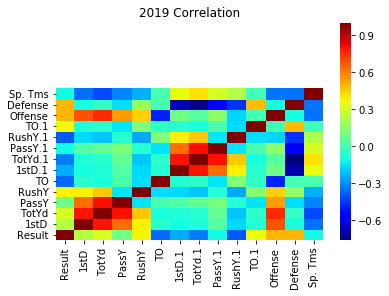

In [6]:
# Correlation Heatmap
corr = df.drop(['Team', 'Week', 'OT', 'Loc', 'Opp', 'Tm', 'Opp.1'], axis=1).corr()
plt.figure(1)
sns.heatmap(corr, cmap = 'jet')
plt.ylim(0, 20)
plt.xlim(0, None)
plt.title('2019 Correlation')

Here we made a correlation matrix to visualize which stats were most correlated to wins and losses. Unsurprisingly, high standardized offensive and defensive scores are strongly positively correlated to winning. What is somewhat interesting is that rushing yards is more correlated to winning than passing yards, even as the league continues to trend towards more pass oriented offenses.

In [7]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.iloc[:,6:])
standard_df = pd.DataFrame(scaled_df, columns = ['Tm', 'Opp.1', '1stD', 'TotYd', 'PassY', 'RushY', 'TO', 
                                                '1stD.1', 'TotYd.1', 'PassY.1', 'RushY.1', 'TO.1', 'Offense',
                                                'Defense', 'Sp. Tms'])
standard_df.head()

,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,1.004052,-1.952665,0.753728,1.324419,1.656047,-0.264221,-1.089590,-1.056162,-0.450748,0.518627,-1.537591,-0.304963,1.210645,0.987012,-0.156871
1,1.989624,-2.248337,1.357024,0.352034,0.253229,0.210917,-0.304963,-1.860557,-1.852791,-1.174865,-1.347536,2.048920,0.884244,3.042066,-2.362864
2,0.708380,-0.868536,0.150431,0.374648,0.986233,-0.853392,0.479665,-2.866051,-2.746028,-2.097439,-1.461569,-0.304963,-0.103671,2.328264,-1.923627
3,-0.671421,-1.262764,-1.860557,-1.400519,-1.073761,-0.739359,-0.304963,0.552629,0.306807,0.063659,0.419977,2.048920,-1.390259,1.241319,1.194178
4,1.004052,-1.558436,0.552629,1.064363,0.973595,0.324950,-0.304963,-1.860557,-1.411826,-1.983697,0.610033,0.479665,0.496842,1.880651,-1.282418


Here we went ahead and standardized all of our features (stats) so we can perform tests with it later.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(standard_df, df['Result'], test_size = 0.25)

In [9]:
clf = LogisticRegression().fit(x_train, y_train)
predict = clf.predict(x_test)
print(predict)

[1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
print(accuracy_score(y_test, predict))

0.9921875


Here we split our data, built the regression model and tested it. We got a very high accuracy score but our data included the score of each game which pretty much defeats the purpose of what we are trying to do. So we performed the same test again without the scores, in the cells below.

In [11]:
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(standard_df.iloc[:,2:], df['Result'], test_size = 0.25)

In [12]:
standard_df.iloc[:,2:]

,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,0.753728,1.324419,1.656047,-0.264221,-1.089590,-1.056162,-0.450748,0.518627,-1.537591,-0.304963,1.210645,0.987012,-0.156871
1,1.357024,0.352034,0.253229,0.210917,-0.304963,-1.860557,-1.852791,-1.174865,-1.347536,2.048920,0.884244,3.042066,-2.362864
2,0.150431,0.374648,0.986233,-0.853392,0.479665,-2.866051,-2.746028,-2.097439,-1.461569,-0.304963,-0.103671,2.328264,-1.923627
3,-1.860557,-1.400519,-1.073761,-0.739359,-0.304963,0.552629,0.306807,0.063659,0.419977,2.048920,-1.390259,1.241319,1.194178
4,0.552629,1.064363,0.973595,0.324950,-0.304963,-1.860557,-1.411826,-1.983697,0.610033,0.479665,0.496842,1.880651,-1.282418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.351530,-0.789952,-0.277567,-0.910409,0.479665,-0.050667,0.159819,-1.528729,2.567601,-1.089590,-0.579011,0.029201,-0.147066
508,1.357024,-0.032397,0.126849,-0.245216,2.048920,0.351530,1.279192,0.847215,0.876110,-1.089590,-0.043461,-1.336610,-0.992207
509,1.558123,0.747772,0.430161,0.610033,1.264292,0.150431,0.906068,0.493351,0.781082,-0.304963,0.266302,-1.050613,0.762784
510,-0.251766,-0.699498,-0.454499,-0.492287,1.264292,0.954827,-0.269839,-1.629833,1.997435,-1.089590,-1.111393,-0.772539,-1.219669


In [13]:
new_clf = LogisticRegression().fit(new_x_train, new_y_train)
new_predict = new_clf.predict(new_x_test)
print(new_predict)

[0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
print(accuracy_score(new_y_test, new_predict))

0.9765625


In [15]:
accuracy = []
for i in range(30):
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(standard_df.iloc[:,2:], df['Result'], test_size = 0.25)
    new_predict = new_clf.predict(new_x_test)
    accuracy.append(accuracy_score(new_y_test, new_predict))
print(np.mean(accuracy))

0.9713541666666666


After taking out the scores we performed the regression again. Here we wrote a loop to get an average of the accuracy scores if we ran the regression 30 times. Our accuracy is slightly lower than when we included the scores which makes sense. But overall with having an average of 96% accuracy is very good.

In [16]:
df_2020 = pd.read_csv('Project_Data-2020.csv')

In [17]:
df_2020.head()

,Team,Week,Result,OT,Loc,Opp,Tm,Opp.1,1stD,TotYd,...,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,Buffalo Bills,1,W,NaN,NaN,New York Jets,27.0,17.0,31.0,404.0,...,98.0,2.0,15.0,254.0,202.0,52.0,2.0,14.47,0.12,-3.63
1,Buffalo Bills,2,W,NaN,@,Miami Dolphins,31.0,28.0,23.0,523.0,...,112.0,1.0,28.0,410.0,311.0,99.0,NaN,21.16,-12.70,-2.30
2,Buffalo Bills,3,W,NaN,NaN,Los Angeles Rams,35.0,32.0,23.0,375.0,...,101.0,2.0,28.0,478.0,311.0,167.0,2.0,17.83,-19.86,6.79
3,Buffalo Bills,4,W,NaN,@,Las Vegas Raiders,30.0,23.0,21.0,337.0,...,63.0,NaN,24.0,383.0,297.0,86.0,2.0,16.49,-7.20,-1.37
4,Buffalo Bills,5,L,NaN,@,Tennessee Titans,16.0,42.0,23.0,370.0,...,95.0,3.0,25.0,334.0,195.0,139.0,NaN,1.55,-24.29,-0.82


In [18]:
df_2020['OT'] = df['OT'].replace(np.nan, 'None')
df_2020['Loc'] = df['Loc'].replace(np.nan, 'Home')
df_2020['Loc'] = df['Loc'].replace('@', 'Away')
df_2020['TO'] = df['TO'].replace(np.nan, 0)
df_2020['TO.1'] = df['TO.1'].replace(np.nan, 0)
df_2020 = df_2020.dropna()
df_2020 = df_2020.reset_index()
df_2020 = df_2020.drop(columns = 'index')

In [19]:
for i in range(len(df_2020['Result'])):
    if df_2020['Result'].iloc[i] == 'W':
        df_2020['Result'].iloc[i] = 1
    if df_2020['Result'].iloc[i] == 'L':
        df_2020['Result'].iloc[i] = 0
    if df_2020['Result'].iloc[i] == 'T':
        df_2020['Result'].iloc[i] = 0
df_2020.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Team,Week,Result,OT,Loc,Opp,Tm,Opp.1,1stD,TotYd,...,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,Buffalo Bills,1,1,None,Home,New York Jets,27.0,17.0,31.0,404.0,...,98.0,0.0,15.0,254.0,202.0,52.0,1.0,14.47,0.12,-3.63
1,Buffalo Bills,2,1,None,Away,Miami Dolphins,31.0,28.0,23.0,523.0,...,112.0,1.0,28.0,410.0,311.0,99.0,4.0,21.16,-12.70,-2.30
2,Buffalo Bills,3,1,None,Home,Los Angeles Rams,35.0,32.0,23.0,375.0,...,101.0,2.0,28.0,478.0,311.0,167.0,1.0,17.83,-19.86,6.79
3,Buffalo Bills,4,1,None,Away,Las Vegas Raiders,30.0,23.0,21.0,337.0,...,63.0,1.0,24.0,383.0,297.0,86.0,4.0,16.49,-7.20,-1.37
4,Buffalo Bills,5,0,None,Away,Tennessee Titans,16.0,42.0,23.0,370.0,...,95.0,1.0,25.0,334.0,195.0,139.0,2.0,1.55,-24.29,-0.82


Text(0.5, 1, '2020 Correlation')

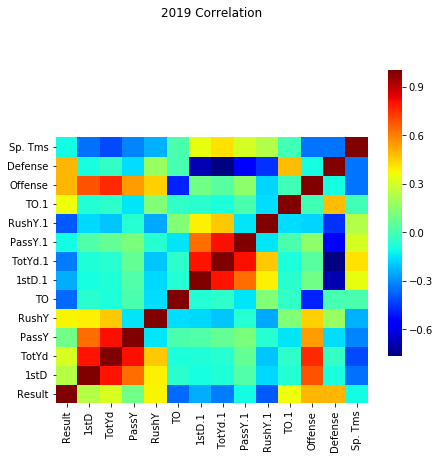

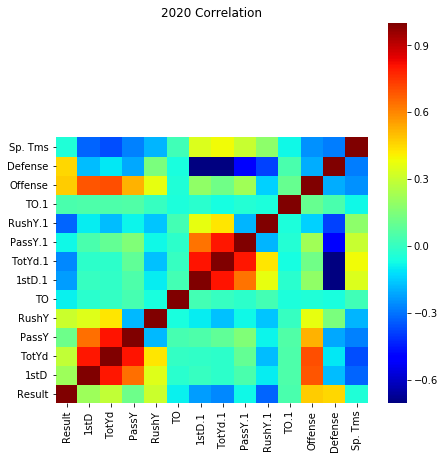

In [20]:
corr = df.drop(['Team', 'Week', 'OT', 'Loc', 'Opp', 'Tm', 'Opp.1'], axis=1).corr()
plt.figure(1, figsize=(7,7))
sns.heatmap(corr, cmap = 'jet', cbar_kws={"shrink": .75})
plt.ylim(0, 20)
plt.xlim(0, None)
plt.title('2019 Correlation')
plt.figure(2, figsize=(7,7))
corr2 = df_2020.drop(['Team', 'Week', 'OT', 'Loc', 'Opp', 'Tm', 'Opp.1'], axis=1).corr()
sns.heatmap(corr2, cmap = 'jet')
plt.ylim(0, 20)
plt.xlim(0, None)
plt.title('2020 Correlation')

Here we wanted to see how the correlation matrices compared with one another from 2019 and 2020. There were not that many difference between the two, however, we did notice what looked like the biggest difference was that turnovers commited by the other team are less correlated to winning in 2020 than in 2019.

In [21]:
scaler2 = StandardScaler()
scaled_df2 = scaler2.fit_transform(df_2020.iloc[:,6:])
scaled_df2 = pd.DataFrame(scaled_df2, columns = ['Tm', 'Opp.1', '1stD', 'TotYd', 'PassY', 'RushY', 'TO', 
                                                '1stD.1', 'TotYd.1', 'PassY.1', 'RushY.1', 'TO.1', 'Offense',
                                                'Defense', 'Sp. Tms'])
scaled_df2.head()

,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,0.212063,-0.839989,1.881641,0.559853,0.831542,-0.341037,-1.080402,-1.357458,-1.229704,-0.502826,-1.265765,-0.330926,0.704472,0.518510,-0.705794
1,0.641063,0.329532,0.255275,1.993121,2.208750,-0.058768,-0.299495,1.241591,0.626157,0.908368,-0.343831,2.014427,1.270990,-0.555761,-0.448306
2,1.070064,0.754812,0.255275,0.210569,0.411821,-0.280551,0.481411,1.241591,1.435122,0.908368,0.990032,-0.330926,0.989001,-1.155744,1.311522
3,0.533813,-0.202069,-0.151317,-0.247113,0.411821,-1.046710,-0.299495,0.441884,0.304950,0.727113,-0.598834,2.014427,0.875528,-0.094880,-0.268258
4,-0.967688,1.818013,0.255275,0.150348,0.424937,-0.401523,-0.299495,0.641811,-0.277980,-0.593453,0.440794,0.450858,-0.389611,-1.526962,-0.161777


In [22]:
predict2 = new_clf.predict(scaled_df2.iloc[:,2:])
print(predict2)

[1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0
 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0
 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0
 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1
 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0
 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1]


In [23]:
print(accuracy_score(df_2020['Result'], predict2))

0.9431818181818182


Here we performed the ultimate test, using the model we created the second time around for the 2019 data, we used all of the 2020 data as one last test. Doing this we found that our model was 94.8% accurate at predicting the correct winner for the 2020 NFL regular season, thus far.

In [24]:
new = np.where(predict2 == 1, 'W', predict2)
newer = np.where(new == '0', 'L', new)

df_2020['Prediction'] = pd.Series(newer)
df_2020 = df_2020.reindex(columns = ['Team', 'Week', 'Result', 'Prediction', 'Opp', 'Tm', 'Opp.1', '1stD', 'TotYd', 
                           'PassY', 'RushY', 'TO', '1stD.1', 'TotYd.1', 'PassY.1', 'RushY.1', 'TO.1', 
                           'Offense','Defense', 'Sp. Tms'])
for i in range(len(df_2020['Result'])):
    if df_2020['Result'].iloc[i] == 1:
        df_2020['Result'].iloc[i] = 'W'
    if df_2020['Result'].iloc[i] == 0:
        df_2020['Result'].iloc[i] = 'L'
df_2020.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Team,Week,Result,Prediction,Opp,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,Buffalo Bills,1,W,W,New York Jets,27.0,17.0,31.0,404.0,306.0,98.0,0.0,15.0,254.0,202.0,52.0,1.0,14.47,0.12,-3.63
1,Buffalo Bills,2,W,W,Miami Dolphins,31.0,28.0,23.0,523.0,411.0,112.0,1.0,28.0,410.0,311.0,99.0,4.0,21.16,-12.70,-2.30
2,Buffalo Bills,3,W,W,Los Angeles Rams,35.0,32.0,23.0,375.0,274.0,101.0,2.0,28.0,478.0,311.0,167.0,1.0,17.83,-19.86,6.79
3,Buffalo Bills,4,W,W,Las Vegas Raiders,30.0,23.0,21.0,337.0,274.0,63.0,1.0,24.0,383.0,297.0,86.0,4.0,16.49,-7.20,-1.37
4,Buffalo Bills,5,L,L,Tennessee Titans,16.0,42.0,23.0,370.0,275.0,95.0,1.0,25.0,334.0,195.0,139.0,2.0,1.55,-24.29,-0.82


Here we wanted to add our prediction into the dataframe and comapre it with all of the other data just to see where our predictions lined up with the actual results.

Out of curiosity, we wanted to see if we could possibly eliminate some stats that we use in our model. We were thinking it might be possible that some features might be unnecessary. So below we created a pca model to see if we would experience some diminishing returns as the number of components would increase in our model.

In [25]:
def check_pca(n_components, x_train, x_test, y_train, y_test):
    pca = PCA(n_components=n_components, whiten=True)
    _ = pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [1e-4,1e-3, .01,0.1 ],
             'kernel': ['linear', 'rbf']}
    model=GridSearchCV(SVC(),param_grid)
    model=model.fit(pca_x_train, y_train)
    print(model.best_estimator_)
    pred_vals=model.predict(pca_x_test)
    accuracy= accuracy_score(y_test, pred_vals)
    return accuracy


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.71875,
 0.7265625,
 0.78125,
 0.8046875,
 0.8125,
 0.8203125,
 0.84375,
 0.875,
 0.890625,
 0.8828125,
 0.9765625,
 0.96875,
 0.984375]

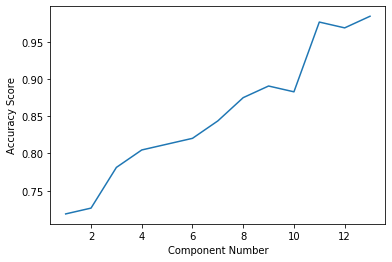

In [26]:
accuracy_scores=[]
for i in range(1,14):
    score=check_pca(i, new_x_train, new_x_test, new_y_train, new_y_test)
    accuracy_scores.append(score)
components=[]
for i in range(1,14):
    components.append(i)
plt.plot(components, accuracy_scores)
plt.xlabel('Component Number')
plt.ylabel('Accuracy Score')
accuracy_scores

Based on our findings from the gridsearch and using our PCA model, it appears that there really are not any diminishing returns in terms of the number of features we use to dictate our accuracy scores. So in order to have the most accurate model possible it looks like we will need to include every stat available to us in our dataframe.

# The End